In [1]:
import re
import types
import abc
import os

from pathlib import Path

import networkx as nx
import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
sdk_root = Path("../sdk").resolve()

In [3]:
def extract_includes(fpath):
    pattern = re.compile(r'\s*#\s*include\s+("(.*?)"|<(.*?)>)\s*',re.M)
    with open(fpath,'r',errors='ignore') as fh:
        src = fh.read()
    for inc in pattern.finditer(src):
        yield inc.group(1)
    

## Explore the SDK dependencies

In [4]:
try: 
    all_sdk_headers
except NameError:
    all_sdk_headers = dict() # name -> dict(path,set(includes))
    for f in sdk_root.glob('**/*.h'):
        all_sdk_headers[f] = set(
            Path(inc[1:-1])
            for inc in extract_includes(f)
        )

try: 
    all_sdk_sources
except NameError:
    all_sdk_sources = dict() # name -> dict(path,set(includes))
    for f in sdk_root.glob('**/*.c'):
        all_sdk_sources[f] = set(
            Path(inc[1:-1])
            for inc in extract_includes(f)
        )
        

In [5]:
header_dependency_graph = nx.DiGraph()

tmp = {}
for hdr in all_sdk_headers:
    for p in hdr.parents:
        tmp.setdefault(hdr.relative_to(p),set()).add(hdr)
    header_dependency_graph.add_node(hdr)
for hdr,incset in all_sdk_headers.items():
    for inc in incset:
        theaders = tmp.get(inc,())
        for theader in theaders:
            header_dependency_graph.add_edge(hdr,theader,weight=1/len(theaders))
#nx.draw(header_dependency_graph, with_labels=True)

In [6]:
def analyse_internal_dependencies(component_root):
    dependency_graph = nx.DiGraph()
    tmp = dict()
    for f in component_root.glob('**/*.[ch]'):
        dependency_graph.add_node(f)
        tmp[f.name] = f
    external_usage = dict()
    for f,inc in list(all_sdk_headers.items()) + list(all_sdk_sources.items()):
        if f.name in tmp:
            continue
        for i in inc:
            i = i.name
            if i not in tmp:
                continue
            external_usage.setdefault(i,set()).add(f)
    for f in component_root.glob('**/*.[ch]'):
        for inc in extract_includes(f):
            i = tmp.get(inc[1:-1])
            if not i:
                continue
            dependency_graph.add_edge(f,i)

    example_root = Path('examples')
    for k,v in external_usage.items():
        shdr,ssrc,ehdr,esrc = collections = tuple(set() for cnt in range(4))
        for f in v:
            is_ex = example_root in f.relative_to(sdk_root).parents
            is_src = f.suffix=='.c'
            collections[is_src+2*is_ex].add(f)
        print(f"Sh={len(shdr):3d} Ss={len(ssrc):3d} Eh={len(ehdr):3d} Es={len(esrc):3d} for {k}")
        if len(shdr)<10:
            for vv in sorted(shdr):
                print(f" - {vv.relative_to(sdk_root)}")
        if len(ssrc)<10:
            for vv in sorted(ssrc):
                print(f" - {vv.relative_to(sdk_root)}")

    pos = graphviz_layout(dependency_graph, prog="neato")

    fig,ax = plt.subplots(1,1,figsize=(14,14))
    nodelist = dependency_graph.nodes()
    nx.draw(
        dependency_graph,
        pos={
            c:(x,y+0.0*x)
            for c,(x,y) in pos.items()
        },
        ax=ax,
        with_labels=True,
        labels={f:str(f.relative_to(component_root)) for f in nodelist},
        nodelist=nodelist,
        node_color=[
            'r' if f.suffix!='.h' else
            'y' if external_usage.get(f.name) else 'b'
            for f in nodelist
        ],
        seed=7,
    )

Sh=  2 Ss=206 Eh=  0 Es=230 for nrf_log.h
 - components/iot/socket/common/socket_trace.h
 - integration/nrfx/nrfx_log.h
Sh=  7 Ss=  0 Eh=  0 Es=  0 for nrf_log_instance.h
 - components/libraries/atomic_fifo/nrf_atfifo.h
 - components/libraries/balloc/nrf_balloc.h
 - components/libraries/block_dev/empty/nrf_block_dev_empty.h
 - components/libraries/block_dev/qspi/nrf_block_dev_qspi.h
 - components/libraries/block_dev/ram/nrf_block_dev_ram.h
 - components/libraries/queue/nrf_queue.h
 - components/libraries/timer/app_timer.h
Sh=  1 Ss=  0 Eh=  0 Es=  0 for nrf_log_backend_interface.h
 - components/libraries/cli/nrf_cli.h
Sh=  1 Ss= 23 Eh=  0 Es=204 for nrf_log_ctrl.h
 - components/libraries/cli/nrf_cli.h
Sh=  0 Ss=  1 Eh=  0 Es=199 for nrf_log_default_backends.h
 - components/iot/socket/common/socket.c
Sh=  0 Ss=  1 Eh=  0 Es=  0 for nrf_log_internal.h
 - components/libraries/cli/nrf_cli.c
Sh=  0 Ss=  1 Eh=  0 Es=  0 for nrf_log_str_formatter.h
 - components/libraries/cli/nrf_cli.c
Sh=  0

/opt/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/opt/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


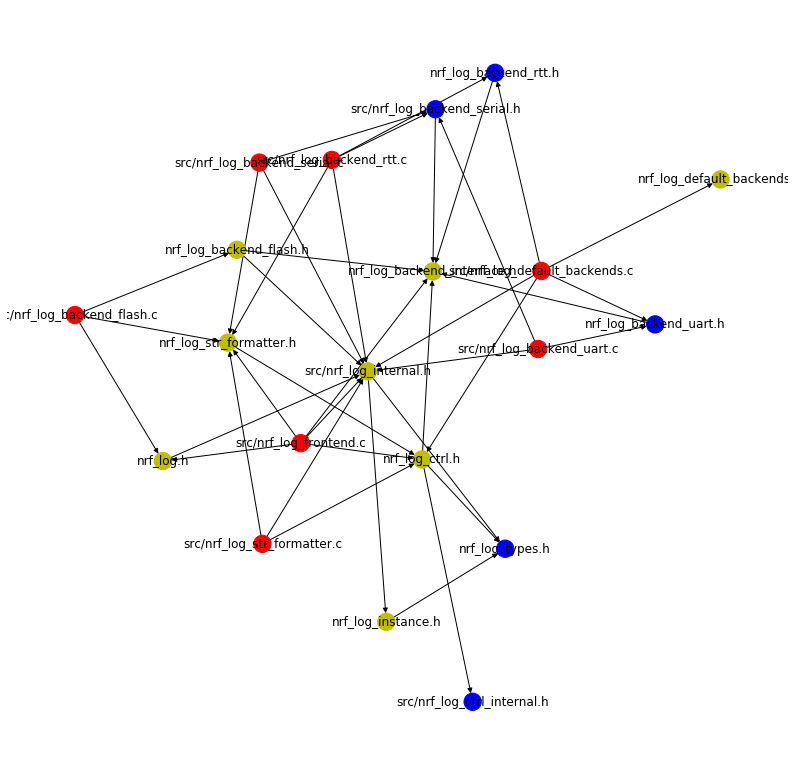

In [7]:
analyse_internal_dependencies(sdk_root / "components/libraries/log")

Sh=  1 Ss=  6 Eh=  3 Es= 30 for nrf_cli.h
 - components/libraries/bsp/bsp_cli.h
 - components/libraries/balloc/nrf_balloc.c
 - components/libraries/experimental_task_manager/task_manager.c
 - components/libraries/log/src/nrf_log_backend_flash.c
 - components/libraries/log/src/nrf_log_frontend.c
 - components/libraries/mpu/nrf_mpu_lib.c
 - components/libraries/queue/nrf_queue.c
Sh=  0 Ss=  0 Eh=  1 Es= 15 for nrf_cli_uart.h
Sh=  0 Ss=  0 Eh=  0 Es=  6 for nrf_cli_rtt.h
Sh=  0 Ss=  0 Eh=  0 Es=  1 for nrf_cli_ble_uart.h
Sh=  0 Ss=  0 Eh=  0 Es=  3 for nrf_cli_types.h
Sh=  0 Ss=  0 Eh=  0 Es=  2 for nrf_cli_libuarte.h
Sh=  0 Ss=  0 Eh=  0 Es=  1 for nrf_cli_cdc_acm.h


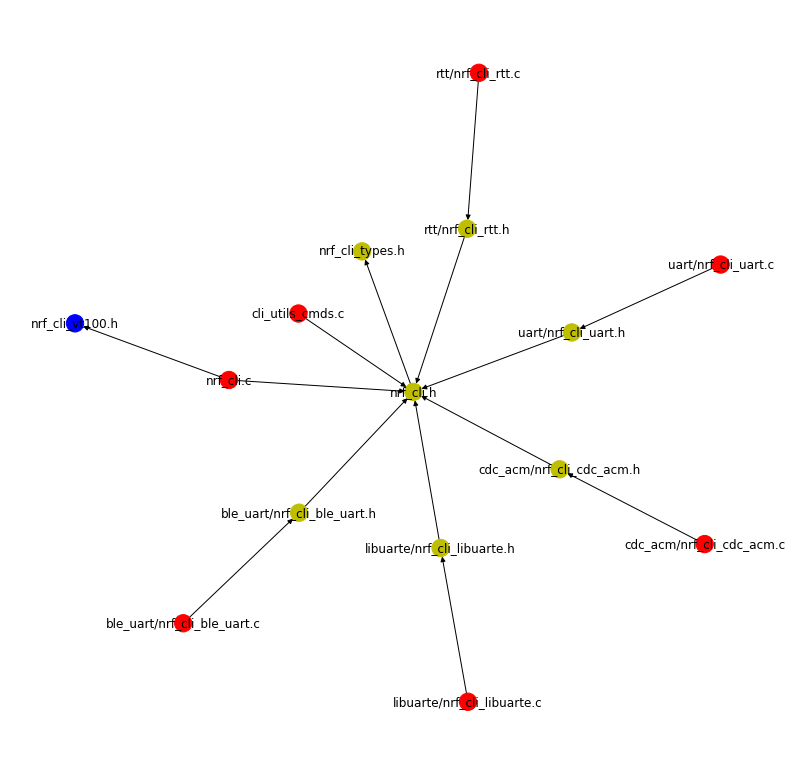

In [8]:
analyse_internal_dependencies(sdk_root / "components/libraries/cli")

Sh=  0 Ss=  0 Eh=  1 Es=  2 for nrf_crypto_aead.h
Sh=  0 Ss=  0 Eh=  1 Es=  2 for nrf_crypto_ecdh.h
Sh=  0 Ss=  0 Eh=  1 Es=  1 for nrf_crypto_hkdf.h
Sh=  0 Ss=  0 Eh=  1 Es=  1 for nrf_crypto_hmac.h
Sh=  0 Ss=  0 Eh=  1 Es=  1 for nrf_crypto_aes.h
Sh=  0 Ss=  0 Eh=  1 Es=  6 for nrf_crypto_hash.h
Sh=  0 Ss=  5 Eh=  0 Es= 43 for nrf_crypto.h
 - components/ble/ble_services/eddystone/es_security.c
 - components/ble/peer_manager/nrf_ble_lesc.c
 - components/libraries/bootloader/dfu/nrf_dfu_req_handler.c
 - components/libraries/bootloader/dfu/nrf_dfu_validation.c
 - components/libraries/bootloader/dfu/nrf_dfu_ver_validation.c
Sh=  0 Ss=  1 Eh=  0 Es=  0 for nrf_crypto_shared.h
 - components/libraries/bootloader/dfu/nrf_dfu_validation.c
Sh=  0 Ss=  0 Eh=  0 Es=  4 for nrf_crypto_ecc.h
Sh=  0 Ss=  0 Eh=  0 Es=  1 for optiga_backend_ecc.h
Sh=  0 Ss=  0 Eh=  0 Es= 10 for nrf_crypto_error.h
Sh=  0 Ss=  0 Eh=  0 Es=  3 for nrf_crypto_ecdsa.h
Sh=  0 Ss=  0 Eh=  0 Es=  3 for nrf_crypto_rng.h
Sh=  

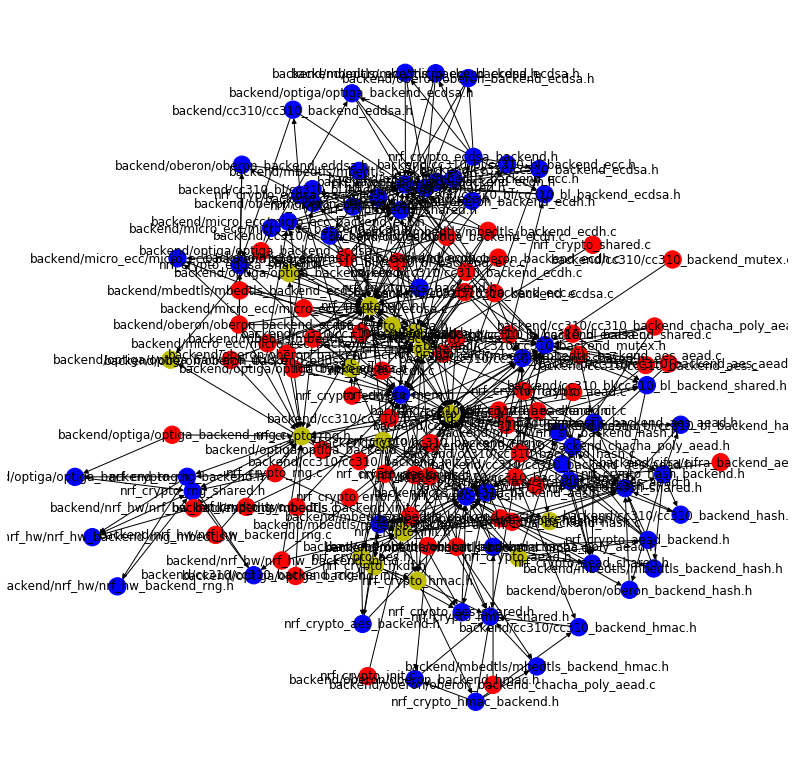

In [9]:
analyse_internal_dependencies(sdk_root / "components/libraries/crypto")

Sh=  1 Ss=  1 Eh=  0 Es=  0 for nrf_dfu_handling_error.h
 - components/iot/background_dfu/background_dfu_operation.h
 - components/iot/background_dfu/background_dfu_block.c
Sh=  1 Ss=  2 Eh=  0 Es=  1 for nrf_dfu_req_handler.h
 - components/iot/background_dfu/background_dfu_state.h
 - components/iot/background_dfu/background_dfu_operation.c
 - components/iot/background_dfu/transport/tftp/tftp_dfu.c
Sh=  0 Ss=  1 Eh=  0 Es=  3 for nrf_bootloader_info.h
 - components/ble/ble_services/ble_dfu/ble_dfu.c
Sh=  0 Ss=  3 Eh=  0 Es=  1 for nrf_dfu_ble_svci_bond_sharing.h
 - components/ble/ble_services/ble_dfu/ble_dfu.c
 - components/ble/ble_services/ble_dfu/ble_dfu_bonded.c
 - components/ble/ble_services/ble_dfu/ble_dfu_unbonded.c
Sh=  0 Ss=  1 Eh=  0 Es=  1 for nrf_dfu_trigger_usb.h
 - components/boards/boards.c
Sh=  0 Ss=  1 Eh=  0 Es=  0 for nrf_dfu_types.h
 - components/iot/background_dfu/background_dfu_state.c
Sh=  0 Ss=  2 Eh=  0 Es=  0 for nrf_dfu_settings.h
 - components/iot/background_

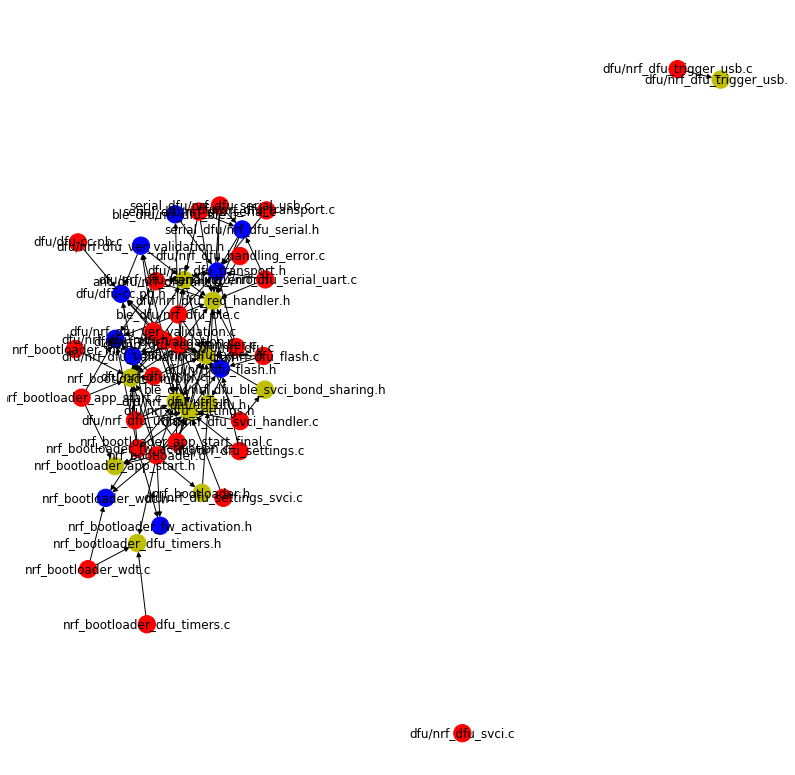

In [10]:
analyse_internal_dependencies(sdk_root / "components/libraries/bootloader")

Sh=  1 Ss=  2 Eh=  0 Es=  4 for app_usbd_cdc_acm.h
 - components/libraries/cli/cdc_acm/nrf_cli_cdc_acm.h
 - components/libraries/bootloader/serial_dfu/nrf_dfu_serial_usb.c
 - components/serialization/common/transport/ser_phy/ser_phy_hci_slip_cdc.c
Sh=  0 Ss=  2 Eh=  0 Es=  4 for app_usbd_serial_num.h
 - components/libraries/bootloader/dfu/nrf_dfu_trigger_usb.c
 - components/libraries/bootloader/serial_dfu/nrf_dfu_serial_usb.c
Sh=  0 Ss=  1 Eh=  0 Es=  0 for app_usbd_nrf_dfu_trigger.h
 - components/libraries/bootloader/dfu/nrf_dfu_trigger_usb.c
Sh=  0 Ss=  2 Eh=  0 Es=  9 for app_usbd.h
 - components/libraries/bootloader/dfu/nrf_dfu_trigger_usb.c
 - components/libraries/bootloader/serial_dfu/nrf_dfu_serial_usb.c
Sh=  0 Ss=  1 Eh=  0 Es=  6 for app_usbd_string_desc.h
 - components/libraries/bootloader/serial_dfu/nrf_dfu_serial_usb.c
Sh=  0 Ss=  1 Eh=  0 Es=  8 for app_usbd_core.h
 - components/libraries/bootloader/serial_dfu/nrf_dfu_serial_usb.c
Sh=  0 Ss=  0 Eh=  0 Es=  1 for app_usbd_a

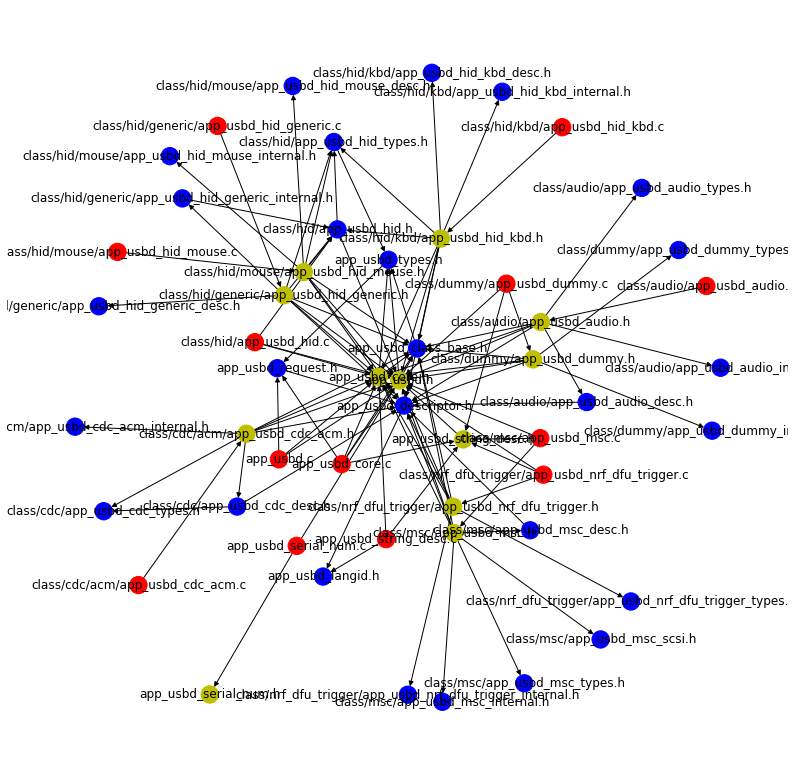

In [11]:
analyse_internal_dependencies(sdk_root / "components/libraries/usbd")

## Declare individual SDK components

In [12]:
class ComponentBase(abc.ABC):
    def __init__(self):
        self.publicly_used_headers = dict() # header -> set(tuple(using component, including header))
    
    def __str__(self):
        return f'Component("{self.name}")'
    __repr__ = __str__
    
    @property
    def list_components(self):
        yield self
    
    @abc.abstractmethod
    def mark_used(self, included_header, component, including_header):
        pass
    
    @property
    def interface_component_dependencies(self):
        return set(
            k for k,v in self.component_dependencies.items()
            if any(including in self.interface_headers for including,included in v)
        )
    
class Component(ComponentBase):    
    def __init__(self, name, *,
         include_dirs,
         interface_headers=(),
         headers,
         sources,
         header_dependencies
    ):
        super().__init__()
        self.name = name
        self.include_dirs = frozenset(include_dirs)
        self.headers = dict(headers) # header-name -> include directory
        self.interface_headers = frozenset(interface_headers)
        self.sources = frozenset(sources)
        self.header_dependencies = dict(header_dependencies) # including file -> set(included headers)
        self.component_dependencies = dict() # dependant component -> set(tuple(including file,included header))
            
    @classmethod
    def parse_spec(cls, name, spec):
        absheaders = dict()
        headers = dict()
        sources = set()
        interface_headers = set()
        include_dirs = set()
        header_dependencies = dict()
        for g in spec.split('\n'):
            g = g.split('#',1)[0].strip()
            if not g:
                continue
            is_private = g.startswith('!')
            if is_private:
                g = g[1:]
            if '|' in g:
                g = g.split('|',1)
                for idir_abs in sdk_root.glob(g[0]):
                    idir = idir_abs.relative_to(sdk_root)
                    include_dirs.add(idir)
                    for hdr in idir_abs.glob(g[1]):
                        absheaders[hdr.relative_to(sdk_root)] = idir
                        hdr = hdr.relative_to(idir_abs)
                        assert idir == headers.get(hdr,idir), f"duplicate header {{ {idir},{headers[hdr]} }} / {hdr}"
                        headers[hdr] = idir
                g = '/'.join(g)
            found = False
            for p in sdk_root.glob(g):
                found = True
                includes = tuple(
                    Path(inc[1:-1])
                    for inc in
                    extract_includes(p)
                )
                p = p.relative_to(sdk_root)
                if p.suffix.endswith('.h'):
                    p = p.relative_to(absheaders[p])
                    if not is_private:
                        interface_headers.add(p)
                else:
                    sources.add(p)
                header_dependencies.setdefault(p,set()).update(includes)
            if not found:
                print(f'WARNING: Glob "{g}" did not produce any files!')
        self = cls(
            name=name,
            headers=headers,
            sources=sources,
            include_dirs=include_dirs,
            interface_headers=interface_headers,
            header_dependencies=header_dependencies,
        )
        for h in interface_headers:
            self.mark_used(h, self, None)
        return self
    
    @classmethod
    def parse_components(cls,**kw):
        return {
            k:cls.parse_spec(k,v) if not isinstance(v, ComponentBase) else v
            for k,v in kw.items()
        }
    
    def mark_used(self, included_header, component, including_header):
        new = set([(included_header,(component,including_header))])
        while new:
            hdr,dep = new.pop()
            if dep in self.publicly_used_headers.get(hdr,()):
                continue
            idir = self.headers.get(hdr,None)
            if idir is None:
                # external dependency
                continue
            assert hdr in self.headers
            self.publicly_used_headers.setdefault(hdr,set()).add(dep)
            new.update(
                (h,(self,hdr))
                for h in
                self.header_dependencies.get(hdr,())
            )

class VariantComponent(ComponentBase):
    def __init__(self, name, variants):
        super().__init__()
        self.name = name
        self.variants = dict(variants) # maps name to Component
        self.headers = headers = dict()
        self.interface_headers = interface_headers = set()
        for v in self.variants.values():
            headers.update(v.headers)
            interface_headers.update(v.interface_headers)
    
    @property
    def list_components(self):
        yield self
        for v in self.variants.values():
            yield from v.list_components
    
    def mark_used(self, hdr, component, including_header):
        assert hdr in self.headers
        for v in self.variants.values():
            if hdr in v.headers:
                v.mark_used(hdr, component, including_header)
        dep = (component, including_header)
        self.publicly_used_headers.setdefault(hdr,set()).add(dep)
        
    @property
    def component_dependencies(self):
        ret = dict()
        for k,v in self.variants.items():
            for d,link in v.component_dependencies.items():
                ret.setdefault(d,set()).update(link)
            # add variants as dependencies without any link
            ret.setdefault(v,set())
        return ret

In [13]:
components = Component.parse_components(
    **{
        f"nrfx_{drv}": f"""
            modules/nrfx/drivers/include|nrfx_{drv}.h
            
            modules/nrfx/drivers/src/nrfx_{drv}.c
        """ for drv in """
            gpiote rtc clock uart uarte twi twim power power_clock ppi timer systick
            spi spim qspi
        """.split()
    },
    nrfx_usbd = """
        modules/nrfx/drivers/include|nrfx_usbd.h
            
        # A header in src? what?
        !modules/nrfx/drivers/src|nrfx_usbd_errata.h
        
        modules/nrfx/drivers/src/nrfx_usbd.c
    """,
    **{
        f"hal_{hal}": f"""
            modules/nrfx|hal/nrf_{hal}.h 
            # it seems that Nordic couldn't decide how to import it's headers
            modules/nrfx/hal|nrf_{hal}.h 
        """ for hal in """
            gpio gpiote rtc nvmc power clock uart uarte twi twim ppi timer usbd systick
            regulators spi spim qspi
        """.split()
    },
    nrfx_atomic = """
        modules/nrfx/soc|nrfx_atomic.h 
        !modules/nrfx/soc|nrfx_atomic_internal.h 
        
        modules/nrfx/soc/nrfx_atomic.c
    """,
    drv_usbd = """
        integration/nrfx/legacy|nrf_drv_usbd.h
            
        !integration/nrfx/legacy|nrf_drv_usbd_errata.h
    """,
    **{  # legacy drivers...
        f"drv_{drv}": f"""
            integration/nrfx/legacy|nrf_drv_{drv}.h

            integration/nrfx/legacy/nrf_drv_{drv}.c
        """ for drv in """
            gpiote rtc clock uart twi ppi timer power spi qspi
        """.split()
    },
    prs = """
        modules/nrfx/drivers/src|prs/*.h
        # STUPID: `nrfx_prs.c` includes `nrfx_prs.h` instead of `prs/nrfx_prs.h`
        !modules/nrfx/drivers/src/prs|nrfx_prs.h

        modules/nrfx/drivers/src/prs/*.c
    """,
    nrfx = """
        integration/nrfx|*.h
        integration/nrfx|legacy/apply_old_config.h
        modules/nrfx|nrfx.h
        modules/nrfx|soc/nrfx_*.h
        modules/nrfx|drivers/nrfx_*.h
    """,
    log_backend_uart = """
        components/libraries/log|nrf_log_backend_uart.h
        components/libraries/log/src/nrf_log_backend_uart.c
    """,
    log_backend_serial = """
        components/libraries/log/src|nrf_log_backend_serial.h
        components/libraries/log/src/nrf_log_backend_serial.c
    """,
    log_backend_flash = """
        components/libraries/log|nrf_log_backend_flash.h
        components/libraries/log/src/nrf_log_backend_flash.c
    """,
    log_backend_rtt = """
        components/libraries/log|nrf_log_backend_rtt.h
        components/libraries/log/src/nrf_log_backend_rtt.c
    """,
    log_default_backends = """
        components/libraries/log|nrf_log_default_backends.h
        components/libraries/log/src/nrf_log_default_backends.c
    """,
    log = """
        # the source component needed for any logging
        components/libraries/log|nrf_log_str_formatter.h
        
        components/libraries/log/src/nrf_log_frontend.c
        components/libraries/log/src/nrf_log_str_formatter.c
    """,
    log_ctrl = """
        components/libraries/log|nrf_log_ctrl.h
        components/libraries/log|nrf_log_backend_interface.h
        !components/libraries/log/src|nrf_log_ctrl_internal.h
    """,
    log_api = """
        # the header only api needed by many other modules
        components/libraries/log|nrf_log.h
        components/libraries/log|nrf_log_types.h
        components/libraries/log|nrf_log_instance.h

        # the following should be private, but it is used by `log` and `cli`
        components/libraries/log/src|nrf_log_internal.h
    """,
    timer = """
        components/libraries/timer|*.h
        
        components/libraries/timer/app_timer.c
        #components/libraries/timer/app_timer_freertos.c
        #components/libraries/timer/app_timer_rtx.c
    """,
    cli_api = """
        components/libraries/cli|nrf_cli.h
        components/libraries/cli|nrf_cli_types.h
    """,
    cli = """
        components/libraries/cli|nrf_cli_vt100.h
        
        components/libraries/cli/nrf_cli.c
        components/libraries/cli/cli_utils_cmds.c
    """,
    usbd_class_msc = """
        components/libraries/usbd/class/msc|*.h

        components/libraries/usbd/class/msc/*.c
    """,
    usbd_class_cdc_acm = """
        components/libraries/usbd/class/cdc/acm|*.h

        components/libraries/usbd/class/cdc/acm/*.c
    """,
    usbd_class_cdc = """
        components/libraries/usbd/class/cdc|*.h
    """,
    usbd_core = """
        components/libraries/usbd|*.h

        components/libraries/usbd/*.c
    """,
    **{
        f"cli_{k}": f"""
            components/libraries/cli/{k}|*.h
            components/libraries/cli/{k}/*.c
        """ for k in (
            d.name for d in sdk_root.glob('components/libraries/cli/*')
            if not d.suffix
        )
    },
    scheduler="""
        components/libraries/scheduler|*.h

        components/libraries/scheduler/app_scheduler.c
        # the following seems to be in direct conflict with the above
        #components/libraries/scheduler/app_scheduler_serconn.c
    """,
    bsp_api="""
        components/libraries/bsp|bsp_config.h
        # need to separate bsp.h from bsp.c, as the latter is not always needed
        # and doesn't compile if not properly configured
        components/libraries/bsp|bsp.h
    """,
    bsp="""
        components/libraries/bsp|bsp.c
    """,
    button_api="""
        components/libraries/button|app_button.h
    """,
    button="""
        components/libraries/button/app_button.c
    """,
    **{
        f"bsp_{k}":f"""
            components/libraries/bsp|bsp_{k}.h

            components/libraries/bsp/bsp_{k}.c
        """ for k in """
            cli btn_ant btn_ble nfc
        """.split()
    },
    hardfault = """
        components/libraries/hardfault|*.h

        components/libraries/hardfault/*.c
        # TODO: support nRF51?
        components/libraries/hardfault/nrf52/handler/hardfault_handler_gcc.c
    """,
    **{
        f"block_dev_{k}":f"""
            components/libraries/block_dev/{k}|*.h

            components/libraries/block_dev/{k}/*.c
        """ for k in """
            qspi ram sdc empty
        """.split()
    },
    app_uart_api = """
        components/libraries/uart|*.h
    """,
    app_uart_blocking = """
        components/libraries/uart/app_uart.c
    """,
    app_uart_fifo = """
        components/libraries/uart/app_uart_fifo.c
    """,
    **{
        k:f"""
            components/libraries/{k}|*.h

            components/libraries/{k}/*.c
        """ for k in """
            atomic atomic_flags memobj ringbuf
            strerror pwr_mgmt queue
            delay mpu
            balloc
            mutex fds fstorage atomic_fifo
            crc16 sortlist
            twi_mngr fifo sdcard
            block_dev
        """.split()
    },
    ble_common = """
        components/ble/common|ble_date_time.h
        components/ble/common|ble_gatt_db.h
        components/ble/common|ble_sensor_location.h
    """,
    ble_srv_common = """
        # a circular dependency between ble_common and util requires us to put the header there
        components/ble/common/ble_srv_common.c
    """,
    **{
        f"ble_{k}":f"""
            components/ble/common|ble_{k}.h

            components/ble/common/ble_{k}.c
        """ for k in """
            advdata conn_params conn_state
        """.split()
    },
    **{
        f"ble_{k}":f"""
            components/ble/ble_{k}|*.h

            components/ble/ble_{k}/*.c
        """ for k in """
            advertising db_discovery dtm link_ctx_manager racp radio_notification
        """.split()
    },
    **{
        f"ble_{k}":f"""
            components/ble/nrf_ble_{k}|*.h

            components/ble/nrf_ble_{k}/*.c
        """ for k in """
            gatt qwr scan
        """.split()
    },
    libuarte = """
        components/libraries/experimental_libuarte|nrf_libuarte.h
        components/libraries/experimental_libuarte/nrf_libuarte.c
    """,
    libuarte_async = """
        components/libraries/experimental_libuarte|nrf_libuarte_async.h
        components/libraries/experimental_libuarte/nrf_libuarte_async.c
    """,
    section_vars = """
        components/libraries/experimental_section_vars|nrf_section.h
    """,
    section_iter = """
        components/libraries/experimental_section_vars|nrf_section_iter.h
        components/libraries/experimental_section_vars/nrf_section_iter.c
    """,
    **{
        k:f"""
            components/libraries/experimental_{k}|*.h

            components/libraries/experimental_{k}/*.c
        """ for k in """
            task_manager 
        """.split()
    },
    **{
        k:f"""
            external/{k}|*.h

            external/{k}/*.c
        """ for k in """
            fprintf fnmatch utf_converter
        """.split()
    },
    protothreads = """
        external/protothreads|*.h
        external/protothreads/pt-1.4|*.h
    """,
    segger_rtt = """
        external/segger_rtt|SEGGER_RTT.h
        external/segger_rtt|SEGGER_RTT_Conf.h

        external/segger_rtt/SEGGER_RTT.c
        external/segger_rtt/SEGGER_RTT_printf.c
        external/segger_rtt/SEGGER_RTT_Syscalls_GCC.c
    """,
    fatfs = """
        external/fatfs/src|*.h
        external/fatfs/src/ff.c
        
        external/fatfs/port|*.h
        external/fatfs/port/diskio_blkdev.c
    """,
    boards = """
        components/boards|boards.h
        !components/boards|*.h
        
        components/boards/boards.c
    """,
    util = """
        components/libraries/util|sdk_*.h
        components/libraries/util|nrf_*.h
        
        components/libraries/util|app_util*.h
        components/libraries/util|app_error*.h
        
        components/libraries/util|nordic_common.h
                
        components/libraries/util/app_util_platform.c
        components/libraries/util/nrf_*.c

        # a circular dependency between ble_common and util requires us to put this here...
        components/ble/common|ble_srv_common.h
    """,
    app_error_handler = """
        components/libraries/util/app_error.c
        components/libraries/util/app_error_handler_gcc.c
        #components/libraries/util/app_error_handler_iar.c
        #components/libraries/util/app_error_handler_keil.c
        components/libraries/util/app_error_weak.c
    """,
    softdevice_common = """
        components/softdevice/common|nrf_sdh*.h    
    """,
    softdevice = VariantComponent("softdevice",Component.parse_components(
        **{
            k: f"""
                components/softdevice/{k}/headers|nrf_*.h
                components/softdevice/{k}/headers|ble*.h
                components/softdevice/{k}/headers/nrf52|nrf_mbr.h
            """
            for k in "s112 s132 s140".split() # "s212 s312 s332 s340" do not have headers included in the SDK
        },
        **{
            f"mbr_nrf{k}": f"""
                components/softdevice/mbr/nrf{k}/headers|nrf_*.h
                
                # headers such as nrf_error.h are missing from the MBR folder
                components/drivers_nrf/nrf_soc_nosd|nrf_*.h
            """
            for k in "52810 52832 52840".split()
        },
        nosd = """
            components/drivers_nrf/nrf_soc_nosd|nrf_*.h

            components/drivers_nrf/nrf_soc_nosd/*.c
        """,
    )),
    mdk = VariantComponent("mdk", Component.parse_components(
        nrf52832 = """
                modules/nrfx/mdk|*.h

                modules/nrfx/mdk|nrf.h
                modules/nrfx/mdk|nrf52.h

                modules/nrfx/mdk|compiler_abstraction.h
                modules/nrfx/mdk|nrf_peripherals.h

                #modules/nrfx/mdk/system_nrf52.h

                modules/nrfx/mdk|nrf52.h

                #modules/nrfx/mdk/system_nrf52.h
                #modules/nrfx/mdk/nrf52_to_nrf52.h
                #modules/nrfx/mdk/nrf52_bitfields.h

                #modules/nrfx/soc/nrfx_irqs_nrf52.h

                modules/nrfx/mdk/system_nrf52.c
                modules/nrfx/mdk/gcc_startup_nrf52.S
        """,
        **{ f"nrf{k}": f"""
                modules/nrfx/mdk|*.h

                modules/nrfx/mdk|nrf.h
                modules/nrfx/mdk|nrf52.h

                modules/nrfx/mdk|compiler_abstraction.h
                modules/nrfx/mdk|nrf_peripherals.h

                #modules/nrfx/mdk/system_nrf52.h

                modules/nrfx/mdk|nrf{k}.h

                #modules/nrfx/mdk/system_nrf{k}.h
                #modules/nrfx/mdk/nrf52_to_nrf{k}.h
                #modules/nrfx/mdk/nrf{k}_bitfields.h

                #modules/nrfx/soc/nrfx_irqs_nrf{k}.h

                modules/nrfx/mdk/system_nrf{k}.c
                modules/nrfx/mdk/gcc_startup_nrf{k}.S
            """
           for k in "52810 52811 52840".split()
        },
    )),
    cmsis = """
        components/toolchain/cmsis/include|*.h
    """,
    config = VariantComponent("config", Component.parse_components(
        nrf52840_cfg = """
            config/nrf52840/config|sdk_config.h
        """,
    )),
)

In [14]:
# resolve dependencies
seen_headers = dict() # name -> component
known_headers = dict()
for v in components.values():
    for hdr in v.headers:
        seen_headers.setdefault(hdr,set()).add(v)
    for hdr in v.interface_headers:
        p = known_headers.get(hdr)
        assert p is None, (
            f"Duplicate header: "
            f"{{ {v.name}:{v.headers[hdr]}, {p.name}:{p.headers[hdr]} }}"
            f"/ {hdr}"
        )
        known_headers[hdr] = v
ambiguous_headers = dict()
unambiguous_headers = dict()
for k,v in seen_headers.items():
    if k in known_headers:
        continue
    if len(v) == 1:
        v, = v
        unambiguous_headers[k] = v
    else:
        ambiguous_headers[k] = v
        
unknown_headers = dict()
for f,incs in all_sdk_headers.items():
    includes = set(
        known_headers.get(inc)
        for inc in incs
    )
    includes.discard(None)
    f = f.relative_to(sdk_root)
    for p in f.parents:
        d = unknown_headers.setdefault(f.relative_to(p),dict())
        d[f] = includes



In [15]:
def list_all_components():
    for v in components.values():
         yield from v.list_components

In [16]:
ignored_includes = frozenset(Path(p) for p in """
    stdlib.h stdint.h stdbool.h stddef.h stdio.h string.h stdarg.h
    malloc.h alloca.h ctype.h inttypes.h math.h

    app_config.h
    
    core_cm33.h
    
    ant_error.h ant_parameters.h
    FreeRTOSConfig.h
""".split())

for c in list_all_components():
    c.unmet_dependencies = dict()
    if isinstance(c, VariantComponent):
        # has no own dependencies
        continue
    c.component_dependencies = dict()
    for including,included_set in c.header_dependencies.items():
        for included in included_set:
            if included in c.headers:
                # never declare a dependency to a self-provided header
                # (for variant components, that would create a dependency to the variant set)
                continue
            if included in known_headers:
                dependent = known_headers[included]
            elif included in unambiguous_headers and False:
                dependent = unambiguous_headers[included]
            else:
                if included not in ignored_includes:
                    c.unmet_dependencies[included] = [
                        f"{c.name}" for c in seen_headers.get(included,())
                    ] + [
                        f"\n    - {h} > "+','.join(c.name for c in cset)
                        for h,cset in unknown_headers.get(included,dict()).items()
                    ]
                continue
            dependent.mark_used(included,c,including)
            if dependent is not c:
                c.component_dependencies.setdefault(dependent,set()).add((including,included))

In [17]:
cli_api = components['cli_api']
# ignore build dependency on cli_api - these are optional 
ignore_dependencies = {components[k]:set([cli_api]) for k in """
    log balloc queue task_manager mpu
""".split()}

# ignore other optional dependencies
ignore_dependencies.update({
    components[k]:set([components[vv] for vv in v.split()])
    for k,v in dict(
        # let the user explicitly link to the actual backend implementations
        log_default_backends="log_backend_uart log_backend_rtt log_backend_flash log_backend_serial",
        # fds is only needed when log is configured to load/store the configuration
        log="fds",
    ).items()
})

component_dependency_graph = nx.DiGraph()
component_dependency_graph.add_nodes_from(list_all_components())
for c in list_all_components():
    for dep in c.component_dependencies:
        component_dependency_graph.add_edge(
            c,
            dep,
            ignored = dep in ignore_dependencies.get(c,set()),
            public = dep in c.interface_component_dependencies
        )
        
        

In [18]:

#pos = graphviz_layout(component_dependency_graph, prog="neato")
pos = graphviz_layout(component_dependency_graph, prog="dot")


mpu > cli_api >> task_manager > mpu
queue > cli_api >> queue
balloc > cli_api >> memobj >> balloc
balloc > cli_api >> log_ctrl >> memobj >> balloc
cli_api >> task_manager > cli_api


/opt/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


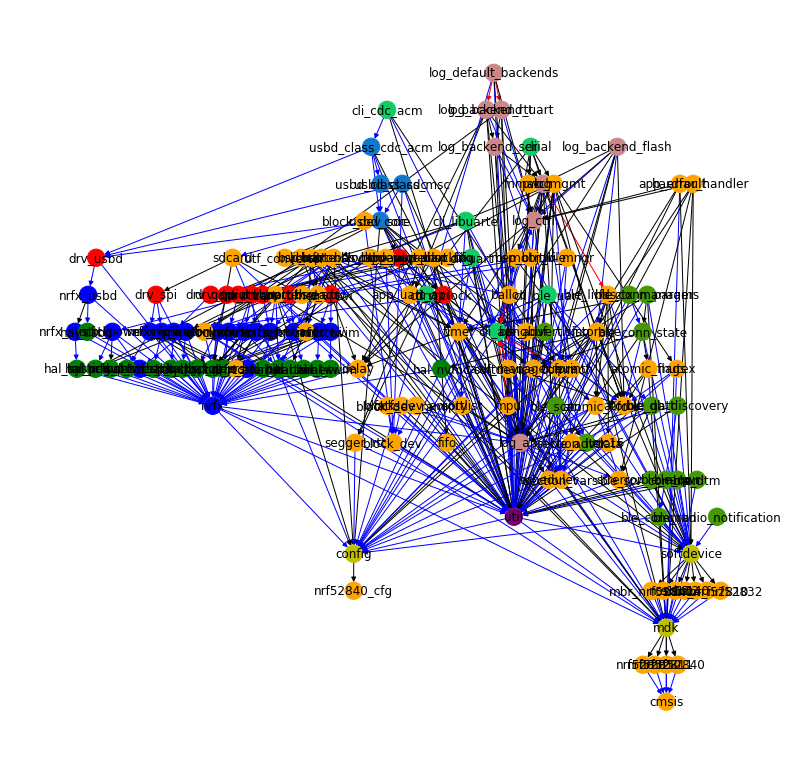

In [19]:
cycles = list(nx.simple_cycles(component_dependency_graph))
cycle_edgemap = {}
for k,cycle in enumerate(cycles):
    cyc = cycle+cycle[:1]
    msg = cyc[0].name
    for s,e in zip(cyc[:-1],cyc[1:]):
        cycle_edgemap[s,e] = k
        msg += ' >> ' if e in s.interface_component_dependencies else ' > '
        msg += e.name
    print(msg)


fig,ax = plt.subplots(1,1,figsize=(14,14))
nodelist = component_dependency_graph.nodes()
edgelist = component_dependency_graph.edges()
edgec = [
    cycle_edgemap.pop(e+(None,),
        'r' if component_dependency_graph.edges[e]['ignored'] else
        'b' if component_dependency_graph.edges[e]['public'] else
        'k'
    )
    for e in edgelist
]
#assert not cycle_edgemap
nx.draw(
    component_dependency_graph,
    pos={
        c:(x,y-0*x)
        for c,(x,y) in pos.items()
    },
    ax=ax,
    with_labels=True,
    labels={c:c.name for c in nodelist},
    nodelist=nodelist,
    node_color=[
        'y' if isinstance(c,VariantComponent) else dict(
            cli='#11cc66',
            log='#cc8888',
            util='#770077',
            drv='r',
            nrfx='b',
            hal='g',
            usbd='#1177cc',
            ble='#449900',
        ).get(c.name.split('_',1)[0],'orange')
        for c in nodelist
    ],
    edge_color = edgec,
    seed=2,
)

In [20]:
cycle = [components[c] for c in "task_manager>cli_api".split('>')]
cycle += cycle[:1]
for s,e in zip(cycle[:-1],cycle[1:]):
    print(f"{s.name} -> {e.name} ","INTERFACE" if e in s.interface_component_dependencies else "PRIVATE")
    dep = s.component_dependencies.get(e,())
    for including,included in dep:
        print(f" - {including} -> {included}")

task_manager -> cli_api  PRIVATE
 - components/libraries/experimental_task_manager/task_manager.c -> nrf_cli.h
cli_api -> task_manager  INTERFACE
 - nrf_cli.h -> task_manager.h


In [21]:
remaining = set(list_all_components())
component_order = []
done_set = set()
while remaining:
    ready = set()
    for k in remaining:
        # all dependencies that are not yet done
        unresolved = set(k.component_dependencies) - done_set
        # ignore ignore
        unresolved -= ignore_dependencies.get(k,set())
        # unless they are interface
        unresolved |= k.interface_component_dependencies - done_set
        if unresolved:
            continue
        ready.add(k)
    if ready:
        component_order.extend(sorted(ready,key=lambda c:c.name))
        remaining -= ready
        done_set |= ready
    else:            
        rem = ' | '.join(
            f"{k.name}>{','.join(sorted(c.name for c in (set(k.component_dependencies)-done_set)))}"
            for k in sorted(remaining,key=lambda c:c.name)
        )
        raise ValueError(f"Not a DAG! "+ '<'.join(c.name for c in component_order) + f" : {rem}")
        component_order.append(k)
        done_set.add(k)
        remaining.remove(k)

In [22]:
for v in component_order:
    if True and not v.unmet_dependencies:
        continue
    print(f"== {v.name} ==")
    if False:
        print('\n'.join(
            ["* Interface headers:"] + 
            [f"  - {f}" for f in sorted(v.interface_headers)]
        ))
        print('\n'.join(
            ["* Publicly used headers:"] + 
            [f"  - {f}" for f in sorted(set(v.publicly_used_headers) - v.interface_headers)]
        ))
        print('\n'.join(
            ["* Exposed headers:"] + 
            [f"  - {f}" for f in sorted(set(v.headers) - v.interface_headers)]
        ))
    else:
        incdirs = set(
            v.headers[h] for h in
            v.interface_headers
        )
        print('\n'.join(
            ["* Interface include-dirs:"] + 
            [f"  - {f}" for f in sorted(incdirs)]
        ))
        seen = incdirs
        
        incdirs = set(
            v.headers[h] for h in
            v.publicly_used_headers
        ) - seen
        print('\n'.join(
            ["* Publicly used include-dirs:"] + 
            [f"  - {f}" for f in sorted(incdirs)]
        ))
        seen.update(incdirs)
        
        incdirs = set(v.headers.values()) - seen
        print('\n'.join(
            ["* Private include-dirs:"] + 
            [f"  - {f}" for f in sorted(incdirs)]
        ))
        seen.update(incdirs)
    print('\n'.join(
        ["* Sources:"] + 
        [f"  - {f}" for f in sorted(getattr(v,'sources',()))]
    ))
    print("* Interface dependencies: " + ','.join(sorted(
        c.name for c,s in
        v.component_dependencies.items()
        if any(including in v.publicly_used_headers for including,included in s)
    )))
    print("* Private dependencies: " + ','.join(sorted(
        c.name for c,s in
        v.component_dependencies.items()
        if not any(including in v.publicly_used_headers for including,included in s)
    )))
    print('\n'.join(
        ["* Missing dependency headers:"] + 
        [
            f"  - {f}: "+','.join(cset)
             for f,cset in sorted(
                 v.unmet_dependencies.items(),
                 key=lambda kv:kv[0]
             )
        ]
    ))
    print()

== cmsis ==
* Interface include-dirs:
  - components/toolchain/cmsis/include
* Publicly used include-dirs:
* Private include-dirs:
* Sources:
* Interface dependencies: 
* Private dependencies: 
* Missing dependency headers:
  - cmsis_ccs.h: 
  - cmsis_csm.h: 
  - cmsis_iar.h: 

== util ==
* Interface include-dirs:
  - components/ble/common
  - components/libraries/util
* Publicly used include-dirs:
* Private include-dirs:
* Sources:
  - components/libraries/util/app_util_platform.c
  - components/libraries/util/nrf_assert.c
* Interface dependencies: config,mdk,softdevice
* Private dependencies: 
* Missing dependency headers:
  - nrf_esb_resources.h: 
    - components/proprietary_rf/esb/nrf_esb_resources.h > 
  - nrf_gzll_resources.h: 
    - components/proprietary_rf/gzll/nrf_gzll_resources.h > 

== segger_rtt ==
* Interface include-dirs:
  - external/segger_rtt
* Publicly used include-dirs:
* Private include-dirs:
* Sources:
  - external/segger_rtt/SEGGER_RTT.c
  - external/segger_rtt/

In [23]:
known_include_dirs = {}
known_sources = {}
for c in list_all_components():
    if isinstance(c, VariantComponent):
        continue
    for h in c.interface_headers:
        d = c.headers[h]
        known_include_dirs.setdefault(d,set()).add(c)
    for s in c.sources:
        assert s not in known_sources
        known_sources[s] = c

In [24]:
outfile = (sdk_root/"../cmake/modules.cmake").resolve()
if not outfile.parent.exists():
    os.mkdir(outfile.parent)
    
with open(outfile,'w') as fh:
    fh.write("""
# This file is generated using "tools/Identify header dependencies.ipynb".
    
# Declare components
function(nrf_declare_sdk_modules target_name sdk_root)
    """)
    pfx = "${target_name}_"
    sdk_root_var = "${sdk_root}"

    available = set()
    
    for c in component_order:
        N = pfx+c.name
        available.add(c)  # actually, only available at the end, but it doesn't matter
        
        if isinstance(c, VariantComponent):
            # we'll declare an alias target later
            continue
        libtype = "STATIC\n" if c.sources else "INTERFACE"
        srcpath = "".join(
            f"    {sdk_root_var}/{s}\n"
            for s in sorted(c.sources)
        )
        # component
        fh.write(f"""
# Component {c.name}
add_library({N} {libtype}{srcpath})
""")
        
        # headers
        public_hdrs = set(
            c.headers[h]/h
            for h in c.publicly_used_headers
        )
        private_hdrs = set(
            c.headers[h]/h
            for h in (
                set(c.headers) - set(c.publicly_used_headers)
            )
        )
        if public_hdrs or private_hdrs:
            pub = "PUBLIC" if c.sources else "INTERFACE"
            public_hdrs = f"    {pub}\n"+"".join(
                f"    {sdk_root_var}/{h}\n"
                for h in sorted(public_hdrs)
            ) if public_hdrs else ""
            priv = "PRIVATE" if c.sources else "INTERFACE"
            private_hdrs = f"    {priv}\n"+"".join(
                f"    {sdk_root_var}/{h}\n"
                for h in sorted(private_hdrs)
            ) if private_hdrs else ""
            fh.write(f"""target_sources({N}\n{public_hdrs}{private_hdrs})\n""")
        
        # include directories
        interface_include_dirs = set(
            c.headers[h] for h in c.publicly_used_headers
        )
        if interface_include_dirs:
            inctype = "PUBLIC" if c.sources else "INTERFACE"
            incpath = "".join(
                f"    {sdk_root_var}/{i}\n"
                for i in sorted(interface_include_dirs)
            )
            fh.write(f"""target_include_directories({N} {inctype}\n{incpath})\n""")
        private_include_dirs = set(c.headers.values()) - interface_include_dirs
        if private_include_dirs:
            incpath = "".join(
                f"    {sdk_root_var}/{i}\n"
                for i in sorted(private_include_dirs)
            )
            inctype = "PRIVATE" if c.sources else "INTERFACE"
            fh.write(f"""target_include_directories({N} {inctype}\n{incpath})\n""")
        
        # dependencies
        deps = set()
        for dep in c.interface_component_dependencies:
            if dep not in available:
                delayed_dependencies.setdefault(dep,set()).add(c)
                continue
            deps.add(dep)
        if deps:
            deps = "".join(
                f"    {pfx+dep.name}\n"
                for dep in sorted(deps,key=lambda c:c.name)
            )
            inctype = "PUBLIC" if c.sources else "INTERFACE"
            fh.write(f"""target_link_libraries({N} {inctype}\n{deps})\n""")

        deps = set()
        for dep in set(c.component_dependencies) - c.interface_component_dependencies - ignore_dependencies.get(c,set()):
            assert dep in available
            deps.add(dep)
        if deps:
            deps = "".join(
                f"    {pfx+dep.name}\n"
                for dep in sorted(deps,key=lambda c:c.name)
            )
            inctype = "PRIVATE" if c.sources else "INTERFACE"
            fh.write(f"""target_link_libraries({N} {inctype}\n{deps})\n""")
        
    fh.write("""
endfunction()
    """)


In [25]:
outfile = (sdk_root/"../cmake/sources.cmake").resolve()
if not outfile.parent.exists():
    os.mkdir(outfile.parent)
    
with open(outfile,'w') as fh:
    fh.write("""
# This file is generated using "tools/Identify header dependencies.ipynb".
    
# Declare (or add, if it already exists) SDK sources to a single target
# Create interface targets for all components
function(nrf_declare_sdk_modules_flat target_name sdk_root components mdk softdevice)
    """)
    target_name_var = "${target_name}"
    sdk_root_var = "${sdk_root}"

    variant_alias = {k:f"${{{k}}}" for k in "mdk softdevice".split()}
    
    fh.write("""
# Collect dependencies for the source build in reverse order
    """)
    for c in component_order[::-1]:
        N = pfx+c.name
        if isinstance(c, VariantComponent):
            alias = variant_alias.get(c.name)
            if alias is None:
                print(f"Ignoring variant {c.name}")
                continue
            f"${{{c.name}}}"
            fh.write(f"""
# Build dependencies of component "{c.name}"
if({c.name}_needed OR ({c.name} IN_LIST components))
    set({c.name}_needed YES)
    # This is actually an alias:
    set({alias}_needed YES)
endif()
""")
            continue

        dependencies = ("\n    # Dependencies:\n    " + "\n    ".join(
            f"set({dep.name}_needed YES)"
            for dep in sorted(
                c.component_dependencies,
                key=lambda dep:dep.name,
            )
        )) if c.component_dependencies else ""
        fh.write(f"""
# Build dependencies of component "{c.name}"
if({c.name}_needed OR ({c.name} IN_LIST components))
    set({c.name}_needed YES){dependencies}
endif()
""")
    
    fh.write("""
# Declare interface libraries for all components, and collect source files
    """)
    
    available = set()
    for c in component_order:
        N = f"{target_name_var}_{c.name}"
        available.add(c)  # actually, only available at the end, but it doesn't matter
        
        if isinstance(c, VariantComponent):
            continue # we declare the aliases externally
            alias = variant_alias.get(c.name)
            if alias is None:
                continue
            fh.write(f"""
# Interface of component "{c.name}"
add_library({N} ALIAS {target_name_var}_{alias})
""")
            continue
        fh.write(f"""
# Interface of component "{c.name}"
add_library({N} INTERFACE)
""")
        # public_headers
        if c.publicly_used_headers:
            public_hdr_path = "".join(
                f"    {sdk_root_var}/{i}\n"
                for i in sorted(
                    c.headers[h]/h
                    for h in c.publicly_used_headers
                )
            )
            fh.write(f"""target_sources({N} INTERFACE\n{public_hdr_path})\n""")
        # include directories
        interface_include_dirs = set(
            c.headers[h] for h in c.publicly_used_headers
        )
        if interface_include_dirs:
            incpath = "".join(
                f"    {sdk_root_var}/{i}\n"
                for i in sorted(interface_include_dirs)
            )
            fh.write(f"""target_include_directories({N} INTERFACE\n{incpath})\n""")
        # dependencies
        deps = set()
        for dep in c.interface_component_dependencies:
            if dep not in available:
                delayed_dependencies.setdefault(dep,set()).add(c)
                continue
            deps.add(dep)
        if deps:
            deps = "".join(
                f"    {pfx+dep.name}\n"
                for dep in sorted(deps,key=lambda c:c.name)
            )
            fh.write(f"""target_link_libraries({N} INTERFACE\n{deps})\n""")
            
        fh.write(f"""
# link component to target
if({c.name}_needed)
    target_link_libraries({target_name_var} PRIVATE {N})
""")
        private_hdrs = set(
            c.headers[h]/h
            for h in (
                set(c.headers) - set(c.publicly_used_headers)
            )
        )
        if private_hdrs or c.sources:
            srcpath = "\n        ".join(
                f"{sdk_root_var}/{s}"
                for s in sorted(c.sources | private_hdrs)
            )
            fh.write(f"""
    target_sources({target_name_var} PRIVATE
        {srcpath}
    )
""")

        private_include_dirs = set(c.headers.values()) - interface_include_dirs
        if private_include_dirs:
            incpath = "\n        ".join(
                f"{sdk_root_var}/{i}"
                for i in sorted(private_include_dirs)
            )
            fh.write(f"""
    target_include_directories({target_name_var} PRIVATE
        {incpath}
    )
""")
        fh.write("""endif()\n""")
        
    fh.write("""
endfunction()
    """)


Ignoring variant config


## Convert examples to CMake

In [26]:
class ExampleProject:
    def __init__(self, **kw):
        for k,v in kw.items():
            setattr(self,k,v)
    
    @classmethod
    def from_gcc_makefile(cls, makefile: Path):
        with open(makefile,'r') as fh:
            src = fh.read()
        src = src.replace('\\\n',' ')
        
        name = re.search(r"^PROJECT_NAME *:= *(\S+?) *$",src,re.M).group(1)
        targets = re.search(r"^TARGETS *:= *(.+?) *$",src,re.M).group(1).split()
        sdk_root = re.search(r"^SDK_ROOT *:= *(.+?) *$",src,re.M).group(1)
        proj_dir = re.search(r"^PROJ_DIR *:= *(.+?) *$",src,re.M).group(1)
        
        def collect(key):
            ret = []
            for m in re.finditer(f"^{key}"+r" *\+= *(.+?) *$",src,re.M):
                ret.extend(m.group(1).split())
            return ret
            
        
        src_files = collect("SRC_FILES")
        inc_folders = collect("INC_FOLDERS")
        lib_files = collect("LIB_FILES")
        
        c_flags = collect("CFLAGS")
        cxx_flags = collect("CXXFLAGS")
        asm_flags = collect("ASMFLAGS")
        ld_flags = collect("LDFLAGS")

        linker_scripts = {
            m.group(1):m.group(2)
            for m in
            re.finditer(r"^ *(.+?) *: *LINKER_SCRIPT *:= *(.+?) *$",src,re.M)
        }
        
        target_flags = dict()
        for t in targets:
            target_flags[t] = types.SimpleNamespace(
                c_flags = collect(f"{t}: *CFLAGS"),
                cxx_flags = collect(f"{t}: *CXXFLAGS"),
                asm_flags = collect(f"{t}: *ASMFLAGS"),
                ld_flags = collect(f"{t}: *LDFLAGS"),
            )
        
        sdk_root = (makefile.parent / sdk_root).resolve()
        proj_dir = (makefile.parent / proj_dir).resolve()
        
        pathmap = {
            "SDK_ROOT": sdk_root,
            "PROJ_DIR": proj_dir,
        }
        def interpret_path(path):
            for k,v in pathmap.items():
                if path.startswith(f'$({k})'):
                    ret = v / path[3+len(k):].lstrip('/')
                    break
            else:
                ret = makefile.parent / path
            assert ret.exists(), f'Path "{ret}" is invalid!'
            return ret
        
        src_files = [interpret_path(p) for p in src_files]
        inc_folders = [interpret_path(p) for p in inc_folders]
        linker_scripts = {k:interpret_path(v) for k,v in linker_scripts.items()}
                
        return cls(
            name = name,
            makefile_path = makefile.parent,
            root = proj_dir,
            sdk_root = sdk_root,
            targets = targets,
            src_files = src_files,
            inc_folders = inc_folders,
            lib_files = lib_files,
            c_flags = c_flags,
            cxx_flags = cxx_flags,
            asm_flags = asm_flags,
            ld_flags = ld_flags,
            target_flags = target_flags,
            linker_scripts = linker_scripts,
        )
    
    def identify_component_dependencies(self):
        interface_components = set()  # direclty included from project sources
        required_components = set()
        missing_sources = set()
        missing_headers = set()
        project_sources = set()
        
        for s in self.src_files:
            if self.root in s.parents:
                project_sources.add(s)
                # this is a project source - determine header dependencies
                for inc in extract_includes(s):
                    inc = Path(inc[1:-1])
                    if inc in ignored_includes:
                        continue
                    c = known_headers.get(inc)
                    if c is None:
                        missing_headers.add(inc)
                    else:
                        interface_components.add(c)
                continue
            s = s.relative_to(self.sdk_root)
            c = known_sources.get(s)
            if c is None:
                missing_sources.add(s)
            else:
                required_components.add(c)

        implied_components = set()
        for c in interface_components | required_components:
            if isinstance(c, VariantComponent):
                continue
            implied_components.update(
                set(c.component_dependencies.keys())
                - ignore_dependencies.get(c,set())
            )
            
        included_components = interface_components | required_components | implied_components
        include_dirs = set()
        compiled_sources = set()
        for c in included_components:
            include_dirs.update(c.headers[h] for h in c.interface_headers)
            if not isinstance(c, VariantComponent):
                compiled_sources.update(c.sources)

        missing_include_dirs = set()
        project_include_dirs = set()
        for i in self.inc_folders:
            if self.root in i.parents or self.root == i:
                project_include_dirs.add(i)
                continue
            i = i.relative_to(self.sdk_root)
            if i not in include_dirs:
                missing_include_dirs.add(i)
        
        required_components = interface_components | (required_components - implied_components)
        
        extraneous_sources = compiled_sources - set(
            p.relative_to(self.sdk_root) for p in self.src_files
        )
        
        return types.SimpleNamespace(
            interface_components = interface_components,
            required_components = required_components,
            implied_components = implied_components - required_components,
            missing_headers = missing_headers,
            missing_sources = missing_sources,
            extraneous_sources = extraneous_sources,
            missing_include_dirs = missing_include_dirs,
            project_sources = project_sources,
            project_include_dirs = project_include_dirs,
        )
    
    def write_cmakelists(self):
        deps = self.identify_component_dependencies()
        here = self.makefile_path
        relative = lambda p,t=self.root: Path(os.path.relpath(p,t))
        outfile = here / "CMakeLists.txt"
        s = self
        target_regex = re.compile(r"-D(NRF\d{5}_XX[A-Z]{2})$")
        target, = [m.group(1) for m in (target_regex.match(d) for d in self.c_flags) if m]
        target = target.lower()
        assert target in self.targets
        sd_regex = re.compile(r"-D(S\d{3})$")
        softdevice = [m.group(1) for m in (sd_regex.match(d) for d in self.c_flags) if m]
        assert bool(softdevice) == ("-DSOFTDEVICE_PRESENT" in self.c_flags)
        assert not (bool(softdevice) and ("-DMBR_PRESENT" in self.c_flags))
        if softdevice:
            assert len(softdevice) == 1
            softdevice = softdevice[0].lower()
        elif "-DMBR_PRESENT" in self.c_flags:
            softdevice = "mbr"
        else:
            softdevice = "nosd"
        sdk_config, = [
            inc for inc in deps.project_include_dirs
            if (self.root in inc.parents or self.root == inc)
            and (inc/"sdk_config.h").exists()
        ]
        depstr = ' '.join(sorted(
            c.name for c in deps.required_components
            if c.name in components # only include top-level components -> aliases are managed by tooling
        ))
        sourcestr = '\n    '.join(sorted(
            f"${{PROJ_DIR}}/{relative(p)}"
            for p in deps.project_sources
        ))
        includedirstr = '\n    '.join(sorted(
            f"${{PROJ_DIR}}/{relative(i)}"
            for i in deps.project_include_dirs
            if i!=sdk_config
        ))
        linker_script_path, = [
            v for k,v in self.linker_scripts.items()
            if k.endswith(f"{target}.out")
        ]
        linker_script_path = f"${{PROJ_DIR}}/{relative(linker_script_path)}"
        linkstr = ' '.join(self.lib_files)
        flagmap = {
            "$(OPT)": "${OPT}"
        }
        handled = """
            -mthumb
            -mabi=
            -mfloat-abi=
            -mcpu=
            -mfpu=
            -DFLOAT_ABI
            -DNRF52810
            -DNRF52811
            -DNRF52832
            -DNRF52840
            -DMBR_PRESENT
            -DSOFTDEVICE_PRESENT
            -DS112 -DS132 -DS140
            -DS212
            -DS312 -DS332 -DS340
        """.split()
        compiledef_str = '\n    '.join(
            flagmap.get(flag,flag)
            for flag in self.c_flags
            if not any(flag.startswith(f) for f in handled)
        )
        target_compiledef_str = '\n    '.join(
            flagmap.get(flag,flag)
            for flag in
            self.target_flags.get(target,types.SimpleNamespace(c_flags=[])).c_flags
            if not any(flag.startswith(f) for f in handled)
        )
        handled_linker_flags = """
            -mthumb
            -mabi=
            -mfloat-abi=
            -mcpu=
            -mfpu=
            -L -T
            --specs
        """.split()
        linker_flags = '\n        '.join(
            flagmap.get(flag,flag)
            for flag in
            self.ld_flags
            if not any(flag.startswith(f) for f in handled_linker_flags)
        )
        with open(outfile,'w') as fh:
            fh.write(f"""
cmake_minimum_required(VERSION 3.12)

project({s.name} C ASM)

set(PROJ_DIR "${{CMAKE_CURRENT_LIST_DIR}}/{relative(s.root,here)}")
set(SDK_ROOT "${{PROJ_DIR}}/{relative(s.sdk_root)}")
set(OPT -O3 -g3)

set(IMAGE_NAME "{s.name}_{target}")

include(${{SDK_ROOT}}/../cmake/nRF5-SDK.cmake)


# SDK static library
nrf_add_image(${{IMAGE_NAME}}
    ADD_SDK_DIRECTLY
    DEVICE {target}
    SOFTDEVICE {softdevice}
    CONFIG_PATH "${{PROJ_DIR}}/{relative(sdk_config)}"
    MODULES {depstr}
    SOURCES {sourcestr}
    LINKER_SCRIPT {linker_script_path}
    LINK_FLAGS {linker_flags}
)
# configure SDK
target_compile_options(${{IMAGE_NAME}}_cfg INTERFACE
    {compiledef_str}
)
# configure image
target_include_directories(${{IMAGE_NAME}} INTERFACE
    {includedirstr}
)
target_link_libraries(${{IMAGE_NAME}} PRIVATE {linkstr})
target_compile_options(${{IMAGE_NAME}} PUBLIC
    {target_compiledef_str}
)
""")

In [27]:
import itertools
example_root = sdk_root / "examples"
    
example_projects = dict()

for makefile in itertools.chain(*(
    example_root.glob(f"{base}/**/pca10056/*/armgcc/Makefile")
    for base in """
        peripheral/blinky
        peripheral/rtc
        peripheral/timer
        peripheral/twi_master_using_nrf_twi_mngr
        peripheral/usbd
        peripheral/usbd_cdc_acm
        peripheral/usbd_msc
    """.split()
)):
#        peripheral/usbd_ble_uart
    proj = ExampleProject.from_gcc_makefile(makefile)
    assert proj.sdk_root == sdk_root
    example_projects.setdefault(proj.root,[]).append(proj)

    print('*** ',makefile.relative_to(sdk_root))
    print(proj.name)
    ret = proj.identify_component_dependencies()
    for k,v in ret.__dict__.items():
        if k.startswith('missing') or k.startswith('project'):
            if not v:
                continue
            print(k)
            for f in v:
                print(f" - ",f.relative_to(sdk_root) if f.is_absolute() else f)
        else:
            if not v:
                continue
            print(f"{k} ="," ".join(c.name for c in v))
    print()
    
    proj.write_cmakelists()

    for v in proj.linker_scripts.values():
        with open(v,'r') as fh:
            src = fh.read()
        dst,n = re.subn(
            r"(GROUP\([^)]*)-lgcc([^)]*\))",
            lambda m:m.group(1)+m.group(2),
            src
        )
        assert n<2
        if n:
            with open(v,'w') as fh:
                fh.write(dst)
            print(f"Updated {n} places in linker script {v.relative_to(sdk_root)}")
        else:
            print(f"No updates in linker script {v.relative_to(sdk_root)}")
    

***  examples/peripheral/blinky/pca10056/blank/armgcc/Makefile
blinky_pca10056
interface_components = boards delay
required_components = log nrfx_atomic app_error_handler boards delay nrf52840
implied_components = memobj hal_gpio cmsis atomic fprintf config mdk strerror balloc util log_api log_ctrl nrfx softdevice section_vars ringbuf cli_api
missing_include_dirs
 -  components/libraries/bsp
 -  components
project_sources
 -  examples/peripheral/blinky/main.c
project_include_dirs
 -  examples/peripheral/blinky
 -  examples/peripheral/blinky/pca10056/blank/armgcc/../config

No updates in linker script examples/peripheral/blinky/pca10056/blank/armgcc/blinky_gcc_nrf52.ld
***  examples/peripheral/blinky/pca10056/mbr/armgcc/Makefile
blinky_pca10056_mbr
interface_components = boards delay
required_components = log nrfx_atomic app_error_handler boards delay nrf52840
implied_components = memobj hal_gpio cmsis atomic fprintf config mdk strerror balloc util log_api log_ctrl nrfx softdevice secti

In [28]:
import yaml

all_targets = set()
for proot,pset in example_projects.items():
    for p in pset:
        for t in p.targets:
            t = f"{p.name}_{t}"
            assert t not in all_targets
            all_targets.add(t)
gitlab_ci = yaml.dump(
    dict(
        image="burnpanck/llvm-armeabi-newlib:8.0",
        stages=["build"],
        **{
            t:dict(
                stage="build",
                tags=["docker"],
                script=[
                    "mkdir build",
                    "cd build",
                    "cmake -GNinja"
                    " -DCMAKE_TOOLCHAIN_FILE=/toolchain/cmake/armv7em-eabi-none-toolchain.cmake"
                    " ..",
                    f"cmake --build . --target {t}",
                ],
            ) for t in sorted(all_targets)
        }
    ),
    default_flow_style=False,
    sort_keys=False,
)
print(gitlab_ci)
with open('../.gitlab-ci.yml','w') as fh:
    fh.write(gitlab_ci)

image: burnpanck/llvm-armeabi-newlib:8.0
stages:
- build
blinky_pca10056_mbr_nrf52840_xxaa:
  stage: build
  tags:
  - docker
  script:
  - mkdir build
  - cd build
  - cmake -GNinja -DCMAKE_TOOLCHAIN_FILE=/toolchain/cmake/armv7em-eabi-none-toolchain.cmake
    ..
  - cmake --build . --target blinky_pca10056_mbr_nrf52840_xxaa
blinky_pca10056_nrf52840_xxaa:
  stage: build
  tags:
  - docker
  script:
  - mkdir build
  - cd build
  - cmake -GNinja -DCMAKE_TOOLCHAIN_FILE=/toolchain/cmake/armv7em-eabi-none-toolchain.cmake
    ..
  - cmake --build . --target blinky_pca10056_nrf52840_xxaa
rtc_pca10056_nrf52840_xxaa:
  stage: build
  tags:
  - docker
  script:
  - mkdir build
  - cd build
  - cmake -GNinja -DCMAKE_TOOLCHAIN_FILE=/toolchain/cmake/armv7em-eabi-none-toolchain.cmake
    ..
  - cmake --build . --target rtc_pca10056_nrf52840_xxaa
timer_pca10056_nrf52840_xxaa:
  stage: build
  tags:
  - docker
  script:
  - mkdir build
  - cd build
  - cmake -GNinja -DCMAKE_TOOLCHAIN_FILE=/toolchain/